## Global model

Modules:

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load MNIST dataset

In [2]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [3]:
from modules.network import GlobalNetwork

learning_rate = 0.1 
momentum = 0.5

model = GlobalNetwork(input_dim=784, hidden_dim=128, output_dim=10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
loss_fn = nn.MSELoss()

print(model)

GlobalNetwork(
  (SST): SST(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=128, bias=True)
    (activation): Sigmoid()
  )
  (PyrGlobal): PyrGlobal(
    (fc1): Linear(in_features=128, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)


In [4]:
for name, param in model.named_parameters():
    print (name)

SST.fc1.weight
SST.fc1.bias
SST.fc2.weight
SST.fc2.bias
SST.fc3.weight
SST.fc3.bias
PyrGlobal.fc1.weight
PyrGlobal.fc1.bias


### Training & Testing

In [5]:
num_epochs = 50
log_interval = 300

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]


def train(epoch, data_loader, model, loss_fn, optimizer):
  model.train()
  loss_avg = 0
  for batch_idx, (data, target) in enumerate(data_loader):
    optimizer.zero_grad()
    top_down, output = model(data)
    t = F.one_hot(target, num_classes=10).float() 
    loss = loss_fn(output, t)
    loss.backward()
    optimizer.step()
    loss_avg += loss.item()

    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(data_loader.dataset)))

      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')
  loss_avg /= len(data_loader)
  print('Epoch: {} Loss: {:.6f}'.format(epoch, loss_avg))


def test(data_loader, model, loss_fn):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      optimizer.zero_grad()
      top_down, output = model(data)
      t = F.one_hot(target, num_classes=10).float() 
      loss = loss_fn(output, t)
      test_loss += loss.item() 
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss = test_loss / len(data_loader.dataset) * batch_size_test
  test_losses.append(test_loss)
  print('Test set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [6]:
test(test_data_loader, model, loss_fn)
for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, loss_fn, optimizer)
  test(test_data_loader, model, loss_fn)

Test set: Avg. loss: 0.259801, Accuracy: 974/10000 (10%)

Epoch: 1 Loss: 0.091280
Test set: Avg. loss: 0.089970, Accuracy: 1135/10000 (11%)

Epoch: 2 Loss: 0.089962
Test set: Avg. loss: 0.089952, Accuracy: 1135/10000 (11%)

Epoch: 3 Loss: 0.089946
Test set: Avg. loss: 0.089927, Accuracy: 1135/10000 (11%)

Epoch: 4 Loss: 0.089931
Test set: Avg. loss: 0.089905, Accuracy: 1135/10000 (11%)

Epoch: 5 Loss: 0.089913
Test set: Avg. loss: 0.089889, Accuracy: 1135/10000 (11%)

Epoch: 6 Loss: 0.089892
Test set: Avg. loss: 0.089876, Accuracy: 1135/10000 (11%)

Epoch: 7 Loss: 0.089874
Test set: Avg. loss: 0.089849, Accuracy: 1135/10000 (11%)

Epoch: 8 Loss: 0.089848
Test set: Avg. loss: 0.089837, Accuracy: 1135/10000 (11%)

Epoch: 9 Loss: 0.089824
Test set: Avg. loss: 0.089791, Accuracy: 1135/10000 (11%)

Epoch: 10 Loss: 0.089791
Test set: Avg. loss: 0.089763, Accuracy: 1135/10000 (11%)

Epoch: 11 Loss: 0.089755
Test set: Avg. loss: 0.089724, Accuracy: 1138/10000 (11%)

Epoch: 12 Loss: 0.089707
Te

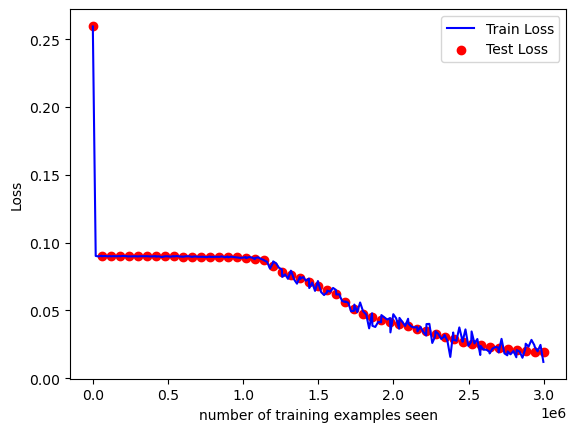

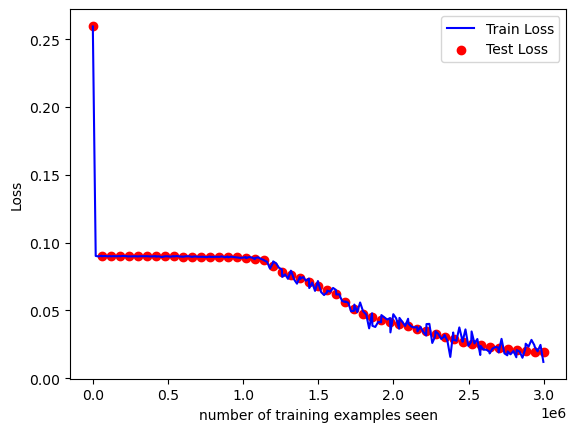

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')
fig